In [ ]:
import math
import pandas as pd

In [ ]:
data_path = '/Users/aprakash/courses/MLI/assignments/three/'

In [ ]:
data = pd.read_csv(f'{data_path}/train.csv')
label_column = 'Survived' # this is the column that denotes 'y' or ground truth

In [ ]:
columns = data.columns.to_list()
columns.remove(label_column)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
X = data[columns].apply(le.fit_transform, axis=0)
y = data[label_column]
feature_names = X.columns

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

## Brute force
### Iterate over all permutations

This is not recommended, but showing you how to do as a learning tool

In [ ]:
from itertools import combinations

best_accuracy = -math.inf
best_combination = None

for three_feat in combinations(X.columns, 3):
    _ = model.fit(X_train[list(three_feat)], y_train)
    accuracy = model.score(X_test[list(three_feat)], y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_combination = three_feat

165it [00:22,  7.27it/s]


In [ ]:
print(f'{best_accuracy} with {best_combination}')

0.8379888268156425 with ('Sex', 'Ticket', 'Fare')


## Logistic Regression

In [ ]:
# logistic regression using sklearn
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

results = []
for feat in X.columns:
    _ = model.fit(X_train[[feat]], y_train)
    accuracy = model.score(X_test[[feat]], y_test)
    results.append({'feature':feat, 'accuracy':accuracy})

df_results = pd.DataFrame.from_records(results).sort_values('accuracy', ascending=False)
df_results

,feature,accuracy
3,Sex,0.782123
1,Pclass,0.703911
8,Fare,0.670391
9,Cabin,0.642458
10,Embarked,0.625698
0,PassengerId,0.586592
2,Name,0.586592
4,Age,0.586592
5,SibSp,0.586592
7,Ticket,0.586592


In [ ]:
three_feat = df_results['feature'][:3]

In [ ]:
# Let's use the three best feature
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train[three_feat], y_train)
accuracy = model.score(X_test[three_feat], y_test)

print(f'Three best features: {three_feat.to_list()}, and the accuracy is {accuracy:.2f}')

Three best features: ['Sex', 'Pclass', 'Fare'], and the accuracy is 0.82


## Sequential Feature Selection
This is a greedy approach - and for each feature decides whether to keep it or remove it

Thus it will yield different result in each direction

This is not a good solution, as your initial order of feature matters

In [ ]:
_ = model.fit(X_train, y_train) # first fit the model on all the features

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs_forward = SequentialFeatureSelector(model, n_features_to_select=3, direction="forward").fit(X, y)
sfs_backward = SequentialFeatureSelector(model, n_features_to_select=3, direction="backward").fit(X, y)

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)

Features selected by forward sequential selection: Index(['Pclass', 'Sex', 'SibSp'], dtype='object')
Features selected by backward sequential selection: Index(['Sex', 'Ticket', 'Fare'], dtype='object')


## Use Feature Selector

### This is better than Greedy

Please read: https://scikit-learn.org/stable/modules/feature_selection.html

In [ ]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)


SelectFromModel(estimator=RandomForestClassifier())

In [ ]:
result = pd.DataFrame.from_dict({'Feature':feature_names, 'Importance':sel.estimator_.feature_importances_, 'Support':sel.get_support()})

In [ ]:
result

,Feature,Importance,Support
0,PassengerId,0.103113,True
1,Pclass,0.055399,False
2,Name,0.108508,True
3,Sex,0.246186,True
4,Age,0.106743,True
5,SibSp,0.027025,False
6,Parch,0.022627,False
7,Ticket,0.126613,True
8,Fare,0.122764,True
9,Cabin,0.060577,False


In [ ]:
import seaborn as sns

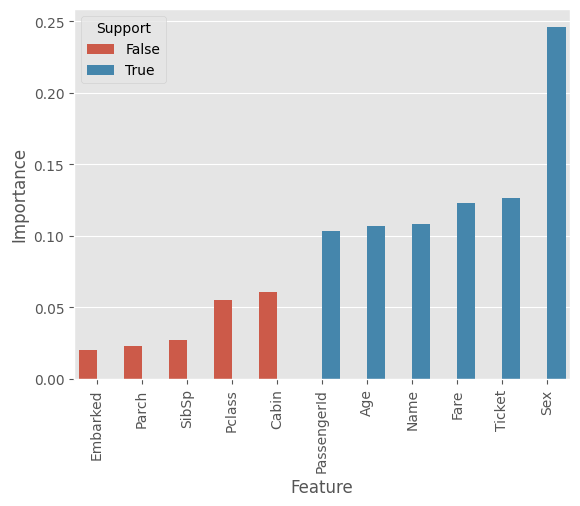

In [ ]:
ax = sns.barplot(data=result.sort_values(by='Importance'), x='Feature', y='Importance', hue='Support')
ax.tick_params(axis='x', rotation=90)

In [ ]:
best_features = result.sort_values(by='Importance', ascending=False)['Feature'][:3]
best_features

3       Sex
7    Ticket
8      Fare
Name: Feature, dtype: object

### Best on this plot, let's use the three best features, and make a new model
# Sex, Ticket, Fare

In [ ]:
_ = model.fit(X_train[best_features], y_train)
model.score(X_test[best_features], y_test)

0.8379888268156425